In [5]:
import numpy as np
import scipy.stats
import json
from collections import defaultdict
from scipy import spatial
import matplotlib.pyplot as plt
from collections import Counter
from validate_semantics import load_wordnet_axes, get_glove_vecs
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
import random

In [6]:
ROOT = '/mnt/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'

### Axes in vector space

In [7]:
axes, axes_vocab = load_wordnet_axes()
glove_vecs = get_glove_vecs(set(), axes_vocab, exp_name='default')

In [8]:
def show_top_axes(path, scores):
    with open(path, 'r') as infile:
        biases = json.load(infile) # {c : { pole : (bias, effect) } }

    for c in biases: 
        print("**** BIAS ****", c)
        vals = []
        dims = []
        for pole in biases[c]: 
            bias_sep, p_val, effect, b_t_f1, b_t_f2 = biases[c][pole]
            # separability + statistical significance
            if scores[pole + '_left'][0] >= 0 and scores[pole + '_right'][0] >= 0 and p_val < 0.05:
                dims.append((pole, round(b_t_f2, 3)))
                vals.append(abs(effect))
        sorted_dims = [x for _,x in sorted(zip(vals,dims))]
        for i in range(1, 6): 
            pole, bias = sorted_dims[-i]
            left, right = axes[pole]
            bias_sep, p_val, effect, b_t_f1, b_t_f2 = biases[c][pole]
            if b_t_f2 > 0 and effect > 0: 
                this_side = left
                degree = 'more'
            elif b_t_f2 > 0 and effect <= 0: 
                this_side = left
                degree = 'less'
            elif b_t_f2 <= 0 and effect > 0: 
                this_side = right
                degree = 'less'
            elif b_t_f2 <= 0 and effect <= 0: 
                this_side = right
                degree = 'more'
            print(round(effect, 3), bias, pole, degree.upper(), '(' + ', '.join(this_side)  + ')')
        print()

In [68]:
def get_occ_sent_counts(): 
    with open(DATA + 'semantics/occupation_sents.json', 'r') as infile: 
        occ_sents = json.load(infile)
    with open(DATA + 'semantics/cleaned/occupations.json', 'r') as infile: 
        lexicon_dict = json.load(infile)
    occ_cat = defaultdict(list)
    for c in lexicon_dict: 
        for occ in lexicon_dict[c]['high']: 
            occ_cat[occ].append(c)
    occ_cat_counts = defaultdict(Counter)
    for occ in occ_sents: 
        for cat in occ_cat[occ]: 
            occ_cat_counts[cat][occ] = len(occ_sents[occ])
    for cat in occ_cat_counts: 
        print(cat.upper())
        print(len(occ_cat_counts[cat]))
        for tup in occ_cat_counts[cat].most_common(): 
            print('\t', tup[0], tup[1])

In [69]:
get_occ_sent_counts()

GOVERNMENT
47
	 mayor 127
	 ombudsman 98
	 governor 56
	 aide-de-camp 44
	 sheriff 32
	 ambassador 28
	 prosecutor 26
	 fence viewer 22
	 acting governor 22
	 official 19
	 alderman 17
	 permanent secretary 15
	 city manager 10
	 attaché 10
	 sovereign 9
	 city attorney 9
	 deputy mayor 8
	 advocate general 8
	 drain commissioner 8
	 undersecretary 7
	 postmaster 6
	 royal secretary 6
	 gold commissioner 6
	 treasurer 5
	 municipal commissioner 5
	 press secretary 4
	 state architect 4
	 appraiser 4
	 county administrator 4
	 tax collector 3
	 courtier 3
	 cultural attaché 3
	 permanent representative 3
	 intelligence officer 3
	 county surveyor 2
	 council architect 2
	 village accountant 2
	 cabinet secretary 2
	 hardship post 2
	 acting president 2
	 bureaucrat 2
	 language commissioner 1
	 pursuivant 1
	 county executive 1
	 sub-divisional magistrate 1
	 municipal clerk 1
	 postal worker 1
HEALTH
47
	 midwife 44
	 pharmacist 32
	 psychologist 29
	 pharmacy technician 24
	 dental as

### Occupation and self-consistency evaluation

In [11]:
def mean_confidence_interval(data, confidence=0.90):
    '''
    copied from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    '''
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def plot_axes_quality(exp_name): 
    quality_file_path = LOGS + 'semantics_val/axes_quality_' + exp_name + '.txt'
    scores = defaultdict(dict) # {synset: {word : (predicted, true)}}
    with open(quality_file_path, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            scores[contents[0]][contents[1]] = (float(contents[2]), contents[3])
    avg_scores = Counter()
    ci_scores = Counter()
    good_count = 0
    for synset in scores: 
        left_scores = []
        right_scores = []
        for w in scores[synset]: 
            if scores[synset][w][1] == 'left': 
                left_scores.append(-1*scores[synset][w][0])
            else: 
                right_scores.append(scores[synset][w][0])
        if left_scores != []: 
            # some are empty since they only had one word with reps
            avg_scores[synset + '_left'] = np.mean(left_scores) 
            ci_scores[synset + '_left'] = mean_confidence_interval(left_scores)
        if right_scores != []: 
            avg_scores[synset + '_right'] = np.mean(right_scores) 
            ci_scores[synset + '_right'] = mean_confidence_interval(right_scores)
        if avg_scores[synset + '_left'] >= 0 and avg_scores[synset + '_right'] >= 0: 
            good_count += 1
    ordered_scores = avg_scores.most_common()
    print("BEST", ordered_scores[:10])
    print("WORST", ordered_scores[::-1][:10])
    plt.hist(avg_scores.values(), density=True, bins=20)
    print("AVG SIMILARITY TO CORRECT SIDE:", np.mean(list(avg_scores.values())))
    print("STANDARD DEVIATION:", np.std(list(avg_scores.values())))
    print("GOOD AXES COUNT:", good_count)
    plt.axvline(x=np.mean(list(avg_scores.values())), color='red')
    plt.ylabel('frequency')
    plt.xlabel('similarity to correct side')
    plt.title(exp_name)
    plt.show()
    return ci_scores

BEST [('cardinal.a.02_right', 0.46587843275706514), ('democratic.a.01_right', 0.45688202820996093), ('established.a.01_right', 0.4457313786380787), ('proved.a.01_right', 0.4400854343410742), ('diligent.a.02_left', 0.4298208091532249), ('used.a.01_left', 0.42174856144216466), ('prospective.a.01_left', 0.4127038229058156), ('partial.a.02_right', 0.3980450580154516), ('nourished.a.01_right', 0.3915070398937059), ('all.a.01_left', 0.3797426857709725)]
WORST [('leeward.a.01_left', -0.2969628124826152), ('left-handed.a.01_left', -0.27629508544904546), ('east.a.01_right', -0.2724861278640515), ('alkaline.a.01_left', -0.2609350143981471), ('western.a.02_left', -0.2469994684001294), ('right-handed.a.01_right', -0.22041623298552349), ('same.a.01_left', -0.21482705170077418), ('left-handed.a.01_right', -0.1928498721136952), ('right.a.01_right', -0.1880249658281328), ('like.a.01_left', -0.18562359995196703)]
AVG SIMILARITY TO CORRECT SIDE: 0.10148170209867674
STANDARD DEVIATION: 0.1126810881944173

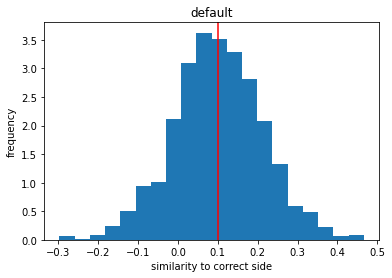

In [47]:
# GloVe 
scores1 = plot_axes_quality('default')

In [48]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_default.json', scores1)

**** BIAS **** Writing
0.095 0.174 original.a.03 MORE (avant-garde, daring, freehand, fresh, germinal, groundbreaking, innovative, new, newfangled, novel, original, seminal)
0.09 0.084 complimentary.a.01 MORE (complimentary, eulogistic, laudatory, panegyric, praising)
-0.083 -0.081 reverent.a.01 MORE (blasphemous, disrespectful, irreverent, profane, sacrilegious)
0.08 0.123 real.a.01 MORE (actual, documentary, existent, factual, historical, objective, real)
0.08 0.112 persuasive.a.01 MORE (coaxing, cogent, compelling, glib, persuasive, telling, weighty)

**** BIAS **** Theater, film, TV, entertainment
0.11 0.167 colorful.a.01 MORE (ablaze, bright, brilliant, changeable, colorful, colourful, deep, fluorescent, iridescent, prismatic, psychedelic, rich, shot, shrill, vibrant, vivid)
0.109 0.182 wanted.a.01 MORE (craved, desired, hot, sought, sought-after, wanted)
0.108 0.161 sound.a.03 MORE (solid, sound, strong, substantial)
0.107 0.174 ample.a.01 MORE (ample, full, generous, good, wide)

BEST [('cosmopolitan.a.02_left', 0.4688037444572688), ('established.a.01_right', 0.4596850064984086), ('diligent.a.02_left', 0.44453673857165804), ('perfect.a.01_right', 0.4236236618175155), ('democratic.a.01_right', 0.42250865007703964), ('coastal.a.02_left', 0.4197461159100794), ('rural.a.01_right', 0.404912632665243), ('loyal.a.01_right', 0.40454635135829137), ('proved.a.01_right', 0.4010928313641157), ('accordant.a.01_right', 0.3786686542925012)]
WORST [('right.a.07_right', -0.24983714360112655), ('middle-class.a.01_right', -0.21872887699865978), ('lower-class.a.01_right', -0.2060201658683339), ('left-handed.a.01_left', -0.2055182739316395), ('carnivorous.a.02_left', -0.20271160378624717), ('bidirectional.a.01_right', -0.2004641383563981), ('simple.a.06_right', -0.18363307685494304), ('plausible.a.01_left', -0.18247291968936494), ('upper-class.a.01_left', -0.18238383433328156), ('right-handed.a.01_right', -0.16924812978017423)]
AVG SIMILARITY TO CORRECT SIDE: 0.08362568852321235
ST

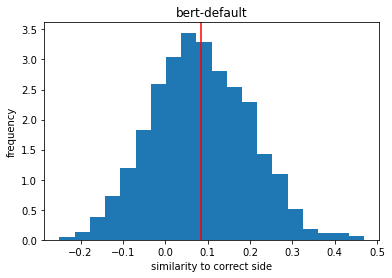

In [49]:
scores2 = plot_axes_quality('bert-default')

In [50]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-default.json', scores2)

**** BIAS **** Writing
0.071 0.16 creative.a.01 MORE (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
0.057 0.079 healthy.a.01 MORE (bouncing, firm, florid, flushed, full-blooded, good, hale, healthy, hearty, lusty, rosy, ruddy, sanguine, sound, well-preserved, whole, wholesome)
0.057 0.138 high.a.04 MORE (adenoidal, altissimo, alto, countertenor, falsetto, high, high-pitched, nasal, peaky, pinched, screechy, sharp, shrill, sopranino, soprano, spiky, squeaking, squeaky, squealing, tenor, treble)
0.056 0.12 controversial.a.01 MORE (arguable, contentious, controversial, debatable, disputable, disputed, moot, polemic, polemical)
0.055 0.147 intellectual.a.02 MORE (good, highbrow, intellectual, rational, reflective, serious, sophisticated)

**** BIAS **** Theater, film, TV, entertainment
0.064 0.146 ready.a.01 MORE (fit, primed, prompt, ready, ripe, set, waiting)
0.058 0.083 healthy.a.01 MORE (bouncing, firm, florid, flushed, full-blooded, good, hale, healthy, hearty

In [51]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-default.json', scores2)

**** BIAS **** Writing
-0.019 0.104 orthodox.a.02 LESS (canonic, canonical, conforming, conformist, conventional, established, orthodox, sanctioned, traditional, unreformed)
0.018 0.095 creative.a.01 MORE (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
0.018 0.006 persuasive.a.01 MORE (coaxing, cogent, compelling, glib, persuasive, telling, weighty)
0.018 0.16 active.a.03 MORE (active, activist, hands-on, proactive)
-0.017 -0.096 pious.a.01 MORE (godless, impious, irreverent)

**** BIAS **** Theater, film, TV, entertainment
0.026 0.09 employed.a.01 MORE (employed, engaged, hired, working)
0.021 0.198 susceptible.a.01 MORE (allergic, amenable, capable, hypersensitive, liable, nonresistant, open, persuadable, pliable, predisposed, sensitised, sensitized, subject, suggestible, supersensitive, susceptible, tractable, unvaccinated, vulnerable)
0.02 0.008 persuasive.a.01 MORE (coaxing, cogent, compelling, glib, persuasive, telling, weighty)
-0.019 0.085 corrigible.a.0

BEST [('established.a.01_right', 0.7294871953224412), ('proved.a.01_right', 0.6003769027690024), ('coastal.a.02_left', 0.534377121387999), ('diligent.a.02_left', 0.516783715891913), ('metallic.a.01_right', 0.49643004925960144), ('democratic.a.01_right', 0.48636240376103274), ('shod.a.01_right', 0.4850944448444688), ('plowed.a.01_left', 0.4707722675369253), ('rural.a.01_right', 0.46622151722676325), ('simple.a.06_left', 0.46490348156035904)]
WORST [('right.a.07_right', -0.3167768528796098), ('simple.a.06_right', -0.2753792586020164), ('bidirectional.a.01_right', -0.26510131944057097), ('lower-class.a.01_right', -0.23113754876505607), ('digestible.a.01_left', -0.2310606702300178), ('right-handed.a.01_right', -0.22672592475482176), ('carnivorous.a.02_left', -0.22394346918759292), ('alkaline.a.01_left', -0.21794843798810126), ('right.a.01_right', -0.2162411538762183), ('middle-class.a.01_right', -0.20458877321276514)]
AVG SIMILARITY TO CORRECT SIDE: 0.11119279037123038
STANDARD DEVIATION: 

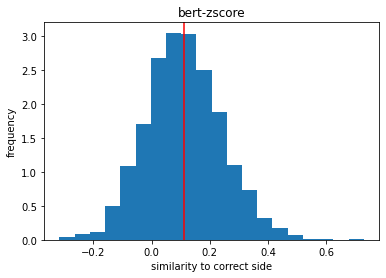

In [52]:
scores3 = plot_axes_quality('bert-zscore')

In [53]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-zscore.json', scores3)

**** BIAS **** Writing
0.084 0.147 creative.a.01 MORE (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
0.059 0.081 controversial.a.01 MORE (arguable, contentious, controversial, debatable, disputable, disputed, moot, polemic, polemical)
-0.058 -0.11 tough.a.07 MORE (chewable, crisp, crispy, flakey, flaky, tender, tenderized)
0.057 0.059 lengthwise.a.01 MORE (axial, end-to-end, fore-and-aft, lengthwise, linear, longitudinal, running)
0.055 0.06 persuasive.a.01 MORE (coaxing, cogent, compelling, glib, persuasive, telling, weighty)

**** BIAS **** Theater, film, TV, entertainment
0.064 0.06 major.a.01 MORE (leading, major, prima, star, starring, stellar)
0.062 0.129 manageable.a.01 MORE (controllable, directed, dirigible, governable, manageable, steerable)
0.058 0.043 healthy.a.01 MORE (bouncing, firm, florid, flushed, full-blooded, good, hale, healthy, hearty, lusty, rosy, ruddy, sanguine, sound, well-preserved, whole, wholesome)
0.057 0.066 ready.a.01 MORE (fit, p

In [54]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-zscore.json', scores3)

**** BIAS **** Writing
-0.026 -0.086 used.a.01 MORE (abused, exploited, misused, put-upon, used, victimised, victimized)
0.024 0.055 corrupt.a.01 MORE (corrupt, corrupted, corruptible, debased, depraved, dirty, dishonest, perverse, perverted, purchasable, putrid, reprobate, sold-out, sordid, venal, vitiated)
0.024 0.03 persuasive.a.01 MORE (coaxing, cogent, compelling, glib, persuasive, telling, weighty)
-0.024 -0.014 dignified.a.01 MORE (demeaning, humbling, humiliating, mortifying, pathetic, ridiculous, silly, undignified)
0.024 0.098 active.a.03 MORE (active, activist, hands-on, proactive)

**** BIAS **** Theater, film, TV, entertainment
0.034 0.033 employed.a.01 MORE (employed, engaged, hired, working)
0.029 0.035 persuasive.a.01 MORE (coaxing, cogent, compelling, glib, persuasive, telling, weighty)
-0.026 0.055 corrigible.a.01 LESS (amendable, correctable, redeemable)
0.024 0.157 spontaneous.a.01 MORE (impulsive, instinctive, intuitive, natural, self-generated, spontaneous, unprom

BEST [('rural.a.01_right', 0.5079529104935544), ('supported.a.01_left', 0.4998363262025115), ('certain.a.02_right', 0.45720223887760286), ('free.a.02_right', 0.4423543961243689), ('coastal.a.02_left', 0.42999713194845757), ('appropriate.a.01_right', 0.4296320921141326), ('established.a.01_right', 0.42959920292012543), ('diligent.a.02_left', 0.426470910671979), ('democratic.a.01_right', 0.4200877246084205), ('shaven.a.01_left', 0.4196405020442762)]
WORST [('leeward.a.01_left', -0.3879342295753272), ('upper-class.a.01_left', -0.2538857094663233), ('left-handed.a.01_right', -0.2180710724155836), ('fast.a.03_left', -0.215623939337331), ('perpendicular.a.01_right', -0.20909917376953585), ('carnivorous.a.02_left', -0.20271160378624717), ('conclusive.a.01_right', -0.2018900829636054), ('bidirectional.a.01_right', -0.2004641383563981), ('binaural.a.01_left', -0.19882697605066216), ('right.a.01_right', -0.18252207393523703)]
AVG SIMILARITY TO CORRECT SIDE: 0.09901751975695801
STANDARD DEVIATION

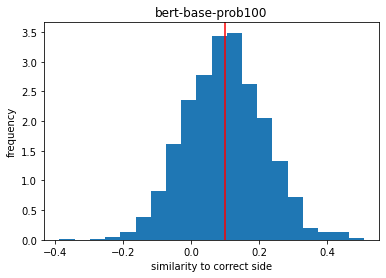

BEST [('established.a.01_right', 0.6993109478210755), ('supported.a.01_left', 0.6919462365810196), ('rural.a.01_right', 0.6161120167537171), ('free.a.02_right', 0.5978805635832115), ('certain.a.02_right', 0.5895949033941624), ('appropriate.a.01_right', 0.5297432920972936), ('coastal.a.02_left', 0.5177359368834074), ('diligent.a.02_left', 0.4965931522441744), ('shaven.a.01_left', 0.48942386798341314), ('proved.a.01_right', 0.48674222596695227)]
WORST [('leeward.a.01_left', -0.42026067075301327), ('analytic.a.03_left', -0.2728206991136306), ('fast.a.03_left', -0.2665459619274105), ('bidirectional.a.01_right', -0.26510131944057097), ('binaural.a.01_left', -0.24970407693071262), ('right.a.01_right', -0.23275079359457163), ('center.a.02_left', -0.22449327753182663), ('carnivorous.a.02_left', -0.22394346918759292), ('upper-class.a.01_left', -0.2217013949520717), ('left-handed.a.01_right', -0.20392589048735674)]
AVG SIMILARITY TO CORRECT SIDE: 0.1278290542854911
STANDARD DEVIATION: 0.13375296

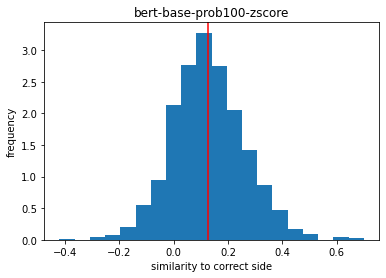

BEST [('neutral.a.04_left', 0.5179562695603912), ('supported.a.01_left', 0.4960966472001016), ('diligent.a.02_left', 0.46456751366352966), ('free.a.02_right', 0.45776361195863513), ('democratic.a.01_right', 0.4378322028960426), ('established.a.01_right', 0.43272816673444964), ('perfect.a.01_right', 0.43248183884603464), ('homemade.a.01_right', 0.4300192820145284), ('upper-class.a.01_right', 0.42889013844737084), ('coastal.a.02_left', 0.42168218857871054)]
WORST [('leeward.a.01_left', -0.41532336221550425), ('left-handed.a.01_right', -0.2658001986684154), ('middle-class.a.01_right', -0.22917487176534454), ('fast.a.03_left', -0.22536532240567778), ('binaural.a.01_left', -0.2086092842998165), ('conclusive.a.01_right', -0.20273746002538004), ('carnivorous.a.02_left', -0.20271160378624717), ('bidirectional.a.01_right', -0.2004641383563981), ('objective.a.01_left', -0.18517732651430033), ('aggressive.a.01_right', -0.18077605995247295)]
AVG SIMILARITY TO CORRECT SIDE: 0.10184461478423383
STAN

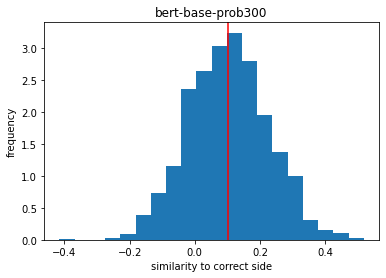

BEST [('supported.a.01_left', 0.7043552694986422), ('established.a.01_right', 0.6999857262149071), ('neutral.a.04_left', 0.6483677612091925), ('free.a.02_right', 0.6335047814459684), ('proved.a.01_right', 0.5288132096422237), ('enclosed.a.01_right', 0.5201514641967183), ('coastal.a.02_left', 0.516749594935013), ('diligent.a.02_left', 0.5077916843176904), ('competent.a.01_right', 0.5067040050703289), ('intended.a.01_right', 0.5063328554542935)]
WORST [('leeward.a.01_left', -0.4587471610061489), ('left-handed.a.01_right', -0.3006249187097694), ('analytic.a.03_left', -0.2964747578109648), ('right-handed.a.01_right', -0.29292882686901306), ('fast.a.03_left', -0.28391337917116455), ('right.a.01_right', -0.275476890525091), ('bidirectional.a.01_right', -0.26510131944057097), ('binaural.a.01_left', -0.23536408619417518), ('simple.a.06_right', -0.22929867040989171), ('carnivorous.a.02_left', -0.22394346918759292)]
AVG SIMILARITY TO CORRECT SIDE: 0.13513912177671944
STANDARD DEVIATION: 0.139199

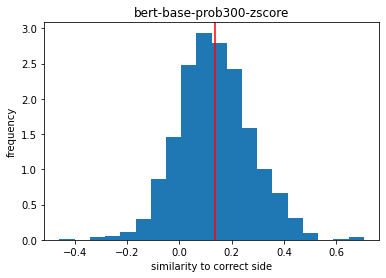

BEST [('neutral.a.04_left', 0.5225176599163684), ('supported.a.01_left', 0.5129855891803874), ('diligent.a.02_left', 0.4674412104474132), ('free.a.02_right', 0.45034484384257406), ('democratic.a.01_right', 0.4361055396402518), ('upper-class.a.01_right', 0.4347686788403358), ('established.a.01_right', 0.42968386716969337), ('homemade.a.01_right', 0.4252743167131219), ('perfect.a.01_right', 0.42485260517326684), ('loyal.a.01_right', 0.4204348206382797)]
WORST [('leeward.a.01_left', -0.41050471204284233), ('left-handed.a.01_right', -0.2515199426598954), ('middle-class.a.01_right', -0.23068176569088122), ('binaural.a.01_left', -0.21578926796210351), ('conclusive.a.01_right', -0.21131616689877872), ('carnivorous.a.02_left', -0.20271160378624717), ('analytic.a.03_left', -0.2016105539958431), ('fast.a.03_left', -0.20098959444328016), ('bidirectional.a.01_right', -0.2004641383563981), ('simple.a.06_right', -0.1970464274753967)]
AVG SIMILARITY TO CORRECT SIDE: 0.10229304061252699
STANDARD DEVIA

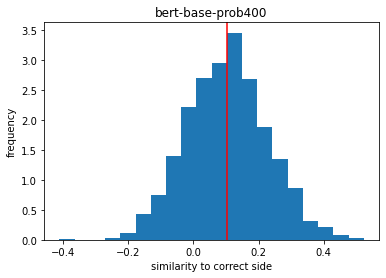

BEST [('supported.a.01_left', 0.7191661294932302), ('established.a.01_right', 0.6993628487579976), ('neutral.a.04_left', 0.6553395924934493), ('free.a.02_right', 0.6326196644025166), ('proved.a.01_right', 0.5427045163621825), ('enclosed.a.01_right', 0.5271480022323338), ('intended.a.01_right', 0.5253105083430732), ('coastal.a.02_left', 0.5247584421541162), ('competent.a.01_right', 0.5205232436182161), ('diligent.a.02_left', 0.5078810487387652)]
WORST [('leeward.a.01_left', -0.4413128218325099), ('analytic.a.03_left', -0.29990364729290686), ('left-handed.a.01_right', -0.2942688833968601), ('right-handed.a.01_right', -0.2915958043823256), ('right.a.01_right', -0.2898784377416405), ('fast.a.03_left', -0.27789547484998495), ('simple.a.06_right', -0.26971542037007407), ('bidirectional.a.01_right', -0.26510131944057097), ('binaural.a.01_left', -0.25001789581180184), ('carnivorous.a.02_left', -0.22394346918759292)]
AVG SIMILARITY TO CORRECT SIDE: 0.1365129395561111
STANDARD DEVIATION: 0.14029

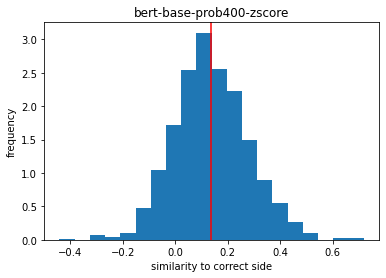

BEST [('supported.a.01_left', 0.5245496178338556), ('neutral.a.04_left', 0.5231244053916415), ('diligent.a.02_left', 0.4736188232271851), ('democratic.a.01_right', 0.45956000347426834), ('free.a.02_right', 0.44409374846491634), ('upper-class.a.01_right', 0.43996275672548335), ('enthusiastic.a.01_right', 0.4394656300631434), ('established.a.01_right', 0.4346264117227662), ('perfect.a.01_right', 0.4267273427609652), ('appropriate.a.01_right', 0.42560931917235556)]
WORST [('leeward.a.01_left', -0.41448076419069274), ('left-handed.a.01_right', -0.24520925458248777), ('binaural.a.01_left', -0.22075011036845607), ('conclusive.a.01_right', -0.21831728542657794), ('analytic.a.03_left', -0.21666590984699796), ('lower-class.a.01_right', -0.21612127606532391), ('middle-class.a.01_right', -0.21378340440842605), ('simple.a.06_right', -0.21126044806608876), ('carnivorous.a.02_left', -0.20271160378624717), ('bidirectional.a.01_right', -0.2004641383563981)]
AVG SIMILARITY TO CORRECT SIDE: 0.1025237983

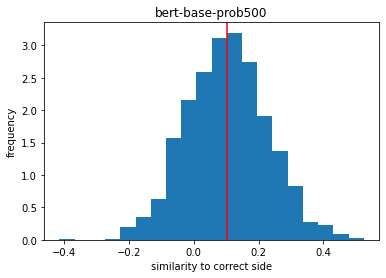

BEST [('supported.a.01_left', 0.727612079392169), ('established.a.01_right', 0.7030245813404042), ('neutral.a.04_left', 0.6618971760236652), ('free.a.02_right', 0.623403772151214), ('proved.a.01_right', 0.5568267447907496), ('competent.a.01_right', 0.5371974049577499), ('intended.a.01_right', 0.5299493630120987), ('enclosed.a.01_right', 0.5272927373920758), ('coastal.a.02_left', 0.5254190609035877), ('diligent.a.02_left', 0.5091604143874116)]
WORST [('leeward.a.01_left', -0.4481856137523778), ('analytic.a.03_left', -0.31124631024658705), ('left-handed.a.01_right', -0.2964886607129758), ('right.a.01_right', -0.28214306216932594), ('simple.a.06_right', -0.2817720875414323), ('right-handed.a.01_right', -0.26966479452759656), ('bidirectional.a.01_right', -0.26510131944057097), ('fast.a.03_left', -0.2557703175089095), ('binaural.a.01_left', -0.24978458204262985), ('carnivorous.a.02_left', -0.22394346918759292)]
AVG SIMILARITY TO CORRECT SIDE: 0.1372562368015527
STANDARD DEVIATION: 0.1409934

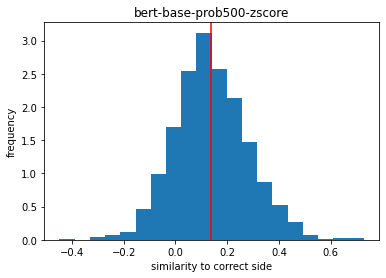

In [55]:
# inspect effect of N on score 
for top_n in [100, 300, 400, 500]: 
    _ = plot_axes_quality('bert-base-prob' + str(top_n))
    _ = plot_axes_quality('bert-base-prob' + str(top_n) + '-zscore')

BEST [('neutral.a.04_left', 0.5225176599163684), ('supported.a.01_left', 0.5129855891803874), ('diligent.a.02_left', 0.4674412104474132), ('free.a.02_right', 0.45034484384257406), ('democratic.a.01_right', 0.4361055396402518), ('upper-class.a.01_right', 0.4347686788403358), ('established.a.01_right', 0.42968386716969337), ('homemade.a.01_right', 0.4252743167131219), ('perfect.a.01_right', 0.42485260517326684), ('loyal.a.01_right', 0.4204348206382797)]
WORST [('leeward.a.01_left', -0.41050471204284233), ('left-handed.a.01_right', -0.2515199426598954), ('middle-class.a.01_right', -0.23068176569088122), ('binaural.a.01_left', -0.21578926796210351), ('conclusive.a.01_right', -0.21131616689877872), ('carnivorous.a.02_left', -0.20271160378624717), ('analytic.a.03_left', -0.2016105539958431), ('fast.a.03_left', -0.20098959444328016), ('bidirectional.a.01_right', -0.2004641383563981), ('simple.a.06_right', -0.1970464274753967)]
AVG SIMILARITY TO CORRECT SIDE: 0.10229304061252699
STANDARD DEVIA

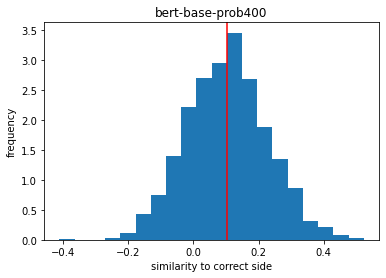

In [21]:
scores7 = plot_axes_quality('bert-base-prob400')

In [22]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-base-prob400.json', scores7)

**** BIAS **** Writing
-0.06 -0.065 nonproprietary.a.01 MORE (branded, copyrighted, patented, proprietary, trademarked)
0.058 0.192 creative.a.01 MORE (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
-0.058 -0.145 fatty.a.01 MORE (fat-free, light, lite, nonfat, skim, skimmed)
0.055 0.118 healthy.a.01 MORE (bouncing, firm, florid, flushed, full-blooded, good, hale, healthy, hearty, lusty, rosy, ruddy, sanguine, sound, well-preserved, whole, wholesome)
0.054 0.086 substantial.a.03 MORE (material, real, substantial)

**** BIAS **** Theater, film, TV, entertainment
0.042 0.139 colorful.a.02 MORE (brave, colorful, colourful, flashy, gaudy, gay, jazzy, many-sided, noisy, picturesque, showy, sporty)
0.041 0.101 healthy.a.01 MORE (bouncing, firm, florid, flushed, full-blooded, good, hale, healthy, hearty, lusty, rosy, ruddy, sanguine, sound, well-preserved, whole, wholesome)
0.039 0.044 susceptible.a.01 MORE (allergic, amenable, capable, hypersensitive, liable, nonresist

In [56]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-base-prob400.json', scores7)

**** BIAS **** Writing
-0.022 0.043 prepared.a.01 LESS (braced, embattled, equipped, preconditioned, precooked, prepared, processed, ready, spread, up)
-0.022 -0.08 noble.a.02 MORE (base, common, humble, ignoble, lowly, plebeian, untitled, unwashed, vulgar)
-0.02 0.002 authorized.a.01 LESS (accredited, approved, authorised, authorized, canonised, canonized, commissioned, empowered, glorified, licenced, licensed, sanctioned)
-0.02 -0.037 nonproprietary.a.01 MORE (branded, copyrighted, patented, proprietary, trademarked)
0.019 0.178 susceptible.a.01 MORE (allergic, amenable, capable, hypersensitive, liable, nonresistant, open, persuadable, pliable, predisposed, sensitised, sensitized, subject, suggestible, supersensitive, susceptible, tractable, unvaccinated, vulnerable)

**** BIAS **** Theater, film, TV, entertainment
-0.023 -0.041 nonproprietary.a.01 MORE (branded, copyrighted, patented, proprietary, trademarked)
0.023 0.181 susceptible.a.01 MORE (allergic, amenable, capable, hypersens

BEST [('supported.a.01_left', 0.7191661294932302), ('established.a.01_right', 0.6993628487579976), ('neutral.a.04_left', 0.6553395924934493), ('free.a.02_right', 0.6326196644025166), ('proved.a.01_right', 0.5427045163621825), ('enclosed.a.01_right', 0.5271480022323338), ('intended.a.01_right', 0.5253105083430732), ('coastal.a.02_left', 0.5247584421541162), ('competent.a.01_right', 0.5205232436182161), ('diligent.a.02_left', 0.5078810487387652)]
WORST [('leeward.a.01_left', -0.4413128218325099), ('analytic.a.03_left', -0.29990364729290686), ('left-handed.a.01_right', -0.2942688833968601), ('right-handed.a.01_right', -0.2915958043823256), ('right.a.01_right', -0.2898784377416405), ('fast.a.03_left', -0.27789547484998495), ('simple.a.06_right', -0.26971542037007407), ('bidirectional.a.01_right', -0.26510131944057097), ('binaural.a.01_left', -0.25001789581180184), ('carnivorous.a.02_left', -0.22394346918759292)]
AVG SIMILARITY TO CORRECT SIDE: 0.1365129395561111
STANDARD DEVIATION: 0.14029

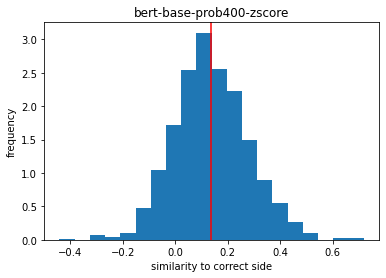

In [57]:
scores8 = plot_axes_quality('bert-base-prob400-zscore')

In [58]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-base-prob400-zscore.json', scores8)

**** BIAS **** Writing
-0.075 -0.075 nonproprietary.a.01 MORE (branded, copyrighted, patented, proprietary, trademarked)
-0.063 -0.016 noble.a.02 MORE (base, common, humble, ignoble, lowly, plebeian, untitled, unwashed, vulgar)
0.063 0.154 creative.a.01 MORE (creative, fanciful, fictive, imaginative, inventive, notional, yeasty)
0.058 0.062 interesting.a.01 MORE (absorbing, amusing, diverting, engrossing, entertaining, fascinating, gripping, interesting, intriguing, newsworthy, riveting)
-0.058 -0.122 alkaline.a.01 MORE (acid, acidic, amphoteric)

**** BIAS **** Theater, film, TV, entertainment
0.074 0.088 major.a.01 MORE (leading, major, prima, star, starring, stellar)
-0.068 -0.139 live.a.01 MORE (canned, filmed, prerecorded, recorded, tape-recorded, taped, transcribed)
-0.066 -0.051 essential.a.02 MORE (incidental, inessential, nonessential, unessential)
0.059 0.003 emotional.a.02 MORE (affective, bathetic, cathartic, charged, drippy, emotional, emotive, funky, hokey, hot-blooded, k

In [67]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-base-prob400-zscore.json', scores8)

**** BIAS **** Writing
-0.03 -0.195 formal.a.01 MORE (casual, daily, everyday, folksy, informal, unceremonious)
-0.029 -0.057 noble.a.02 MORE (base, common, humble, ignoble, lowly, plebeian, untitled, unwashed, vulgar)
-0.029 0.024 prepared.a.01 LESS (braced, embattled, equipped, preconditioned, precooked, prepared, processed, ready, spread, up)
0.028 0.054 corrupt.a.01 MORE (corrupt, corrupted, corruptible, debased, depraved, dirty, dishonest, perverse, perverted, purchasable, putrid, reprobate, sold-out, sordid, venal, vitiated)
-0.028 0.017 orthodox.a.02 LESS (canonic, canonical, conforming, conformist, conventional, established, orthodox, sanctioned, traditional, unreformed)

**** BIAS **** Theater, film, TV, entertainment
0.03 0.052 employed.a.01 MORE (employed, engaged, hired, working)
-0.029 -0.044 nonproprietary.a.01 MORE (branded, copyrighted, patented, proprietary, trademarked)
-0.028 -0.032 depressant.a.01 MORE (adrenocorticotropic, excitatory, irritating, stimulant, stimula

In [57]:
# U-tests
# z-scored bert prob vs. glove
print(mannwhitneyu(list(scores8.values()), list(scores1.values())))
# z-scored bert prob vs. z-scored bert random
print(mannwhitneyu(list(scores8.values()), list(scores3.values())))
# z-scored bert random vs. glove
print(mannwhitneyu(list(scores3.values()), list(scores1.values())))

MannwhitneyuResult(statistic=928174.0, pvalue=8.765265395555834e-08)
MannwhitneyuResult(statistic=761820.0, pvalue=3.8193132107419166e-05)
MannwhitneyuResult(statistic=651919.0, pvalue=1.241232364039564e-22)


# Human evaluation task materials

This section includes metadata used to design the evaluation task, including: 
- example occupations in each category 
- example sentences for each occupation category (taking the first sentence on their page)

In [76]:
with open(DATA + 'semantics/cleaned/occupations.json', 'r') as infile:
    classes = json.load(infile)
with open(DATA + 'semantics/occupation_sents.json', 'r') as infile: 
    occ_sents = json.load(infile)

In [77]:
writers = set(classes['Writing']['high']) 
entertainers = set(classes['Theater, film, TV, entertainment']['high']) 
artists = set(classes['Artistic']['high']) 
print(len(writers & artists) / len(writers))
print(writers & entertainers)
print(writers & artists)

0.03333333333333333
{'screenwriter'}
{'writer'}


In [78]:
num_sents = 0
for c in classes: 
    print([i for i in classes[c]['high'] if i in occ_sents])
    print()
    for i in classes[c]['high']: 
        if i in occ_sents: 
            num_sents += len(occ_sents[i])
            for sent in occ_sents[i]: 
                if len(sent.split()) >= 10: 
                    print(sent)
                break
            print()
    print()
print(num_sents)

['scribe', 'script coordinator', 'novelist', 'staff writer', 'blogger', 'poet', 'copy editor', 'creative consultant', 'script doctor', 'scrivener', 'ghostwriter', 'literary editor', 'songwriter', 'medical writing', 'technical writer', 'journalist', 'commissioning editor', 'writer', 'speechwriter', 'dog writer', 'screenwriter', 'hack writer', 'review', 'author', 'freelancer', 'griot', 'manuscript format']

A scribe is a person who serves as a professional copyist, especially one who made copies of manuscripts before the invention of automatic printing.

A script coordinator is a role in the production of a film or television series.

A novelist is an author or writer of novels, though often novelists also write in other genres of both fiction and non-fiction.

In journalism, a staff writer byline indicates that the author of the article is an employee of the periodical, as opposed to being an independent freelance writer.

Shortly thereafter, Evan Williams at Pyra Labs used "blog" as bo

In [74]:
for c in classes: 
    print([i for i in classes[c]['high'] if i in occ_sents and i.endswith('s')])

[]
[]
[]
[]
[]
[]
['rowers', 'triathletes', 'figure skaters', 'speed skaters', 'swimmers', 'martial artists', 'cricketers', 'jockeys', 'marathoners', 'kickboxers', 'surfers', 'bullfighters', 'boxers', 'cyclists', 'dancers', 'long-distance runners', 'divers', 'skiers', 'football players', 'gymnasts', 'wrestlers', 'archers']
[]
[]
[]
[]
